In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV3Small
from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre, decode_predictions as res_decode
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre, decode_predictions as vgg_decode
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre, decode_predictions as inc_decode
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mn_pre, decode_predictions as mn_decode

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import random

2025-05-12 14:03:01.862731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747051381.890037    6365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747051381.898031    6365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 14:03:01.923723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_names = ("ResNet50", "VGG", "InceptionV3", "MobileNetV3Small")
models = (ResNet50(weights='imagenet'), VGG16(weights='imagenet'), InceptionV3(weights='imagenet'), MobileNetV3Small(weights='imagenet'))
pre_functions = (res_pre, vgg_pre, inc_pre, mn_pre)
decode_functions = (res_decode, vgg_decode, inc_decode, mn_decode)

2025-05-12 14:03:07.340952: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/paul/anaconda3/envs/nlp/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [3]:
def plot_histogram(data, total, label, title, target_label = None):
    if target_label != None:
        plt.bar([label, target_label, "other"], [data[label], data[target_label], total - data[label] - data[target_label]])
        print(f"Targeted evasion rate {((data[target_label]) / total) * 100: .2f}")
    else:
        plt.bar([label, "other"], [data[label], total - data[label]])
        print(f"Evasion rate {((total - data[label]) / total) * 100: .2f}")
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Histogram: ' + title)
    plt.show()

labels = []

In [9]:
def test_model(img_tensors, model, preprocess, decode, flag):
    l = {}
    target_size = (299, 299) if flag == 1 else (224, 224)

    processed_images = []
    for image in img_tensors:
        image = tf.image.resize(image, target_size)
        image = tf.cast(image, tf.float32)
        processed_images.append(image)

    batch = tf.stack(processed_images)
    batch = preprocess(batch)
    predictions = model.predict(batch)
    decoded = decode(predictions, top=1)
    
    for d in decoded:
        _, label, conf = d[0]
        # print(f"Predicted: {label} with {conf*100:.2f}% confidence")
        if label not in l.keys():
            l[label] = 1
        else:
            l[label] += 1

    return l

In [ ]:
source_folder = "./adversarial_images/untargeted/"
image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

total = len(image_files)

image_tensors = []

for img in image_files:

    image_path = tf.keras.utils.get_file(img, 'file://' + source_folder + img)
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw)
    image_tensors.append(image)

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Predicted: banana with 99.94% confidence
Predicted: rapeseed with 93.02% confidence
Predicted: banana with 23.17% confidence
Predicted: banana with 99.81% confidence
Predicted: banana with 44.25% confidence
Predicted: banana with 89.13% confidence
Predicted: banana with 91.83% confidence
Predicted: banana with 98.77% confidence
Predicted: banana with 96.68% confidence
Predicted: banana with 99.99% confidence
Predicted: banana with 99.08% confidence
Predicted: conch with 33.39% confidence
Predicted: banana with 32.52% confidence
Predicted: banana with 99.58% confidence
Predicted: banana with 88.96% confidence
Predicted: banana with 99.83% confidence
Predicted: banana with 100.00% confidence
Predicted: banana with 76.42% confidence
Predicted: banana with 99.73% confidence
Predicted: banana with 100.00% confidence
Predicted: banana with 58.77% confidence
Predicted: banana with 100.00% confidence
Predicted: banana with 97.15% confidence
Predicted: banan

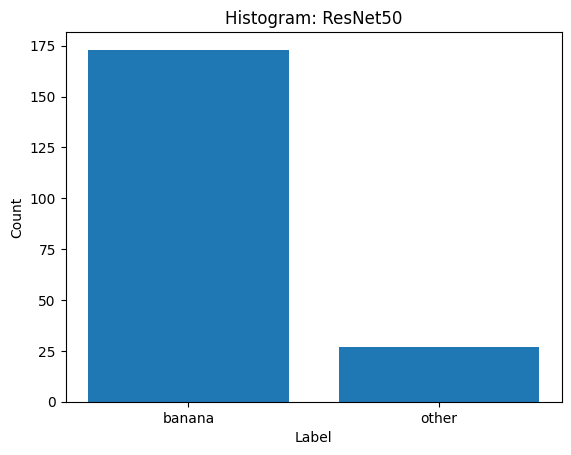

7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
Predicted: banana with 99.99% confidence
Predicted: banana with 98.79% confidence
Predicted: hermit_crab with 54.14% confidence
Predicted: banana with 76.56% confidence
Predicted: banana with 73.87% confidence
Predicted: banana with 94.69% confidence
Predicted: banana with 42.01% confidence
Predicted: banana with 97.47% confidence
Predicted: banana with 68.62% confidence
Predicted: banana with 99.64% confidence
Predicted: banana with 99.50% confidence
Predicted: butternut_squash with 23.08% confidence
Predicted: snail with 11.51% confidence
Predicted: banana with 83.02% confidence
Predicted: banana with 38.80% confidence
Predicted: banana with 99.93% confidence
Predicted: banana with 100.00% confidence
Predicted: banana with 29.01% confidence
Predicted: banana with 99.77% confidence
Predicted: banana with 99.62% confidence
Predicted: dough with 36.13% confidence
Predicted: banana with 99.66% confidence
Predicted: banana with 99.38% confidence
Predic

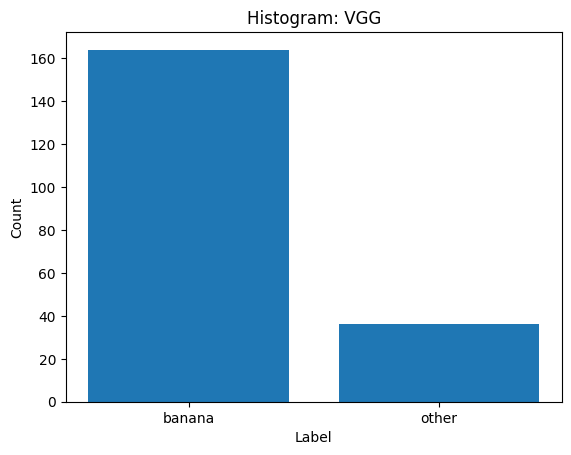

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Predicted: banana with 99.99% confidence
Predicted: banana with 91.52% confidence
Predicted: banana with 28.30% confidence
Predicted: banana with 95.19% confidence
Predicted: banana with 95.70% confidence
Predicted: banana with 98.87% confidence
Predicted: banana with 97.89% confidence
Predicted: banana with 98.19% confidence
Predicted: banana with 99.95% confidence
Predicted: banana with 89.26% confidence
Predicted: banana with 99.97% confidence
Predicted: espresso with 19.58% confidence
Predicted: banana with 52.01% confidence
Predicted: banana with 87.79% confidence
Predicted: banana with 97.62% confidence
Predicted: banana with 99.94% confidence
Predicted: banana with 99.95% confidence
Predicted: banana with 61.30% confidence
Predicted: banana with 99.97% confidence
Predicted: banana with 100.00% confidence
Predicted: banana with 97.00% confidence
Predicted: banana with 99.98% confidence
Predicted: banana with 99.53% confidence
Predicted: banana

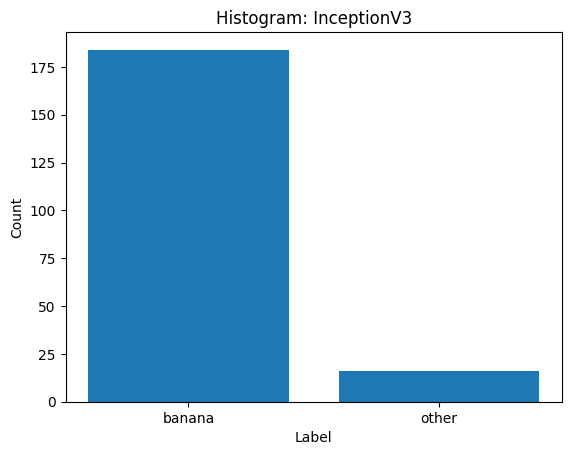

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step
Predicted: banana with 96.95% confidence
Predicted: rapeseed with 59.44% confidence
Predicted: buckeye with 13.93% confidence
Predicted: banana with 26.58% confidence
Predicted: banana with 92.24% confidence
Predicted: conch with 49.68% confidence
Predicted: banana with 52.65% confidence
Predicted: banana with 36.07% confidence
Predicted: banana with 25.72% confidence
Predicted: banana with 18.64% confidence
Predicted: banana with 86.65% confidence
Predicted: conch with 25.14% confidence
Predicted: banana with 27.71% confidence
Predicted: banana with 92.02% confidence
Predicted: banana with 43.71% confidence
Predicted: banana with 97.25% confidence
Predicted: banana with 92.72% confidence
Predicted: banana with 67.15% confidence
Predicted: banana with 94.90% confidence
Predicted: banana with 95.47% confidence
Predicted: French_loaf with 14.73% confidence
Predicted: banana with 89.88% confidence
Predicted: banana with 70.04% confidence
Predicted: b

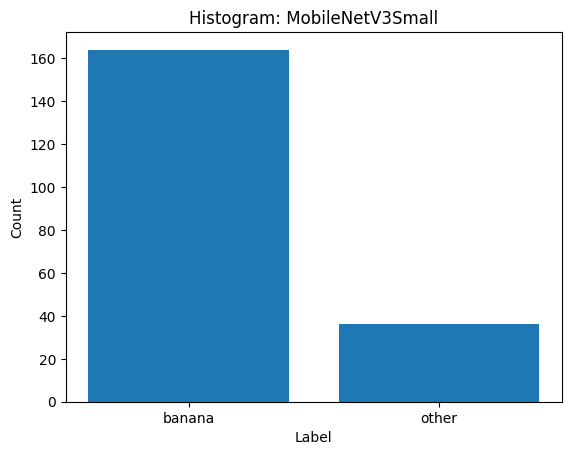

In [8]:
# Plot models
for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    model.trainable = False
    if name == "InceptionV3":
        labels = test_model(image_tensors, model, pre, dec, 1)
    else:
        labels = test_model(image_tensors, model, pre, dec, 0)
    
    plot_histogram(labels, total, "banana", name)

In [ ]:
source_folder = "./adversarial_images/targeted"
image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

total = len(image_files)

image_tensors = []

for img in image_files:

    image_path = tf.keras.utils.get_file(img, 'file://' + source_folder + img)
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw)
    image_tensors.append(image)

17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Targeted evasion rate  1.53


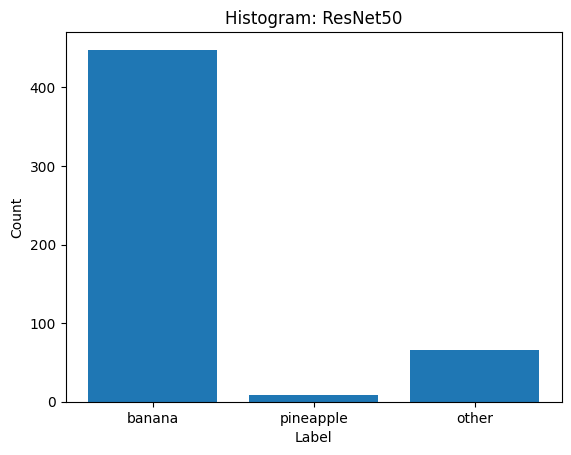

17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step
Targeted evasion rate  1.92


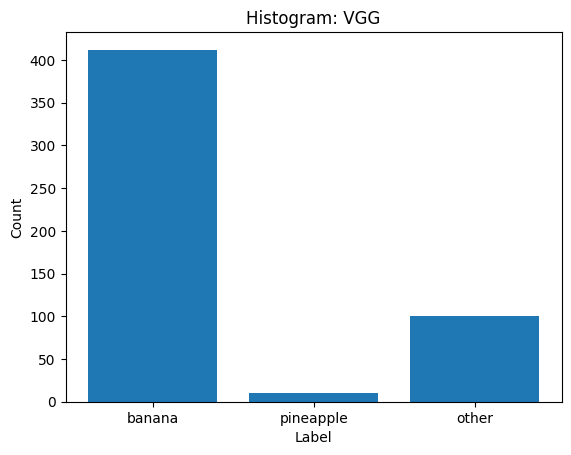

17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Targeted evasion rate  1.53


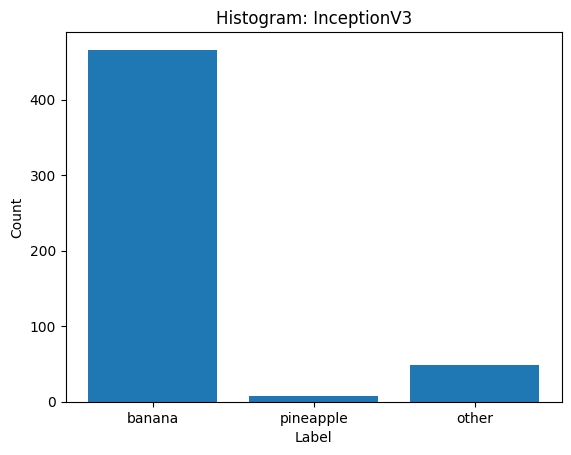

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
Targeted evasion rate  1.34


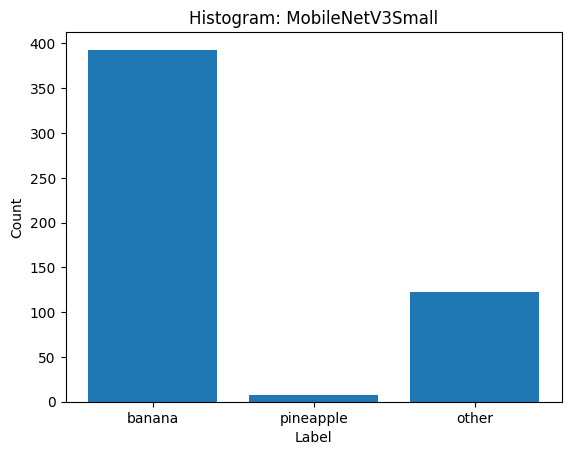

In [193]:
# Plot models
for model, name, pre, dec in zip(models, model_names, pre_functions, decode_functions):
    model.trainable = False
    if name == "InceptionV3":
        labels = test_model(image_tensors, model, pre, dec, 1)
    else:
        labels = test_model(image_tensors, model, pre, dec, 0)
    
    plot_histogram(labels, total, "banana", name, "pineapple")

In [151]:
def build_small_model(input_shape=(64, 64, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [152]:
# Create dummy dataset
x_train = tf.random.uniform((100, 64, 64, 3), minval=0, maxval=1)
y_train = tf.random.uniform((100,), minval=0, maxval=10, dtype=tf.int32)

model = build_small_model()
model.fit(x_train, y_train, epochs=5, batch_size=16)

AttributeError: 'list' object has no attribute 'Sequential'